# Sample preprocessing notebook

### Built for the semi-automatic preprocessing of [Neuroelectrics Starstim](https://www.neuroelectrics.com/solutions/starstim/20) EEG data.

####  For more help visit [this](https://github.com/weiglszonja/eeg-preprocessing/blob/master/notebooks/run_preprocessing.ipynb) notebook.

## Import packages

In [24]:
import os
from pathlib import Path
from ipyfilechooser import FileChooser

from eeg_preprocessing.preprocessing import *
from eeg_preprocessing.utils.io_raw import read_raw, create_epochs_from_raw
from eeg_preprocessing.utils.montage import set_raw_montage_from_locs

from matplotlib import pyplot as plt
%matplotlib qt

## Load raw data

Note that .easy files cannot be processed with MNE, there is a workaround though.
First export the .easy files to .edf using the Neuroelectrics application, or EEGLAB within Matlab. 

In [25]:
# Set base path to EEG data
base_path = '/Volumes/raw_data_EEG/'

# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
interim_path = os.path.join(base_path, folder_name)

# Use the widget to navigate to the experiment folder path and select an EEG file 
fc = FileChooser(base_path)
fc.filter_pattern = ['*.edf']

display(fc)

FileChooser(path='/Volumes/raw_data_EEG', filename='', title='HTML(value='', layout=Layout(display='none'))', …

In [26]:
# Load selected file
raw = read_raw(raw_file_path=fc.selected, add_info=False)
print(raw.info)

Extracting EDF parameters from /Volumes/crnl-memo-hd/raw_data_EEG/20210514172935_12_EEG PALT alatt.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 8 non-empty values
 bads: []
 ch_names: P8, T8, F8, F4, C4, P4, Fp2, Fp1, Fz, Cz, O1, Oz, O2, Pz, P3, ...
 chs: 23 EEG
 custom_ref_applied: False
 fid: 20210514172935_12_EEG PALT alatt.easy_converted_
 highpass: 0.1 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-05-14 17:29:44 UTC
 nchan: 23
 projs: []
 sfreq: 500.0 Hz
>


In [94]:
raw.info['Participant'] = 12

The channel coordinates are missing from the raw file, we are adding it separately here.

The locations file was downloaded from the Neuroelectrics homepage, make sure it is correct.

In [32]:
# Set montage to raw
montage_file_path = 'Starstim32.locs'
raw = set_raw_montage_from_locs(montage_file_path=montage_file_path, raw=raw)

Applying channel locations to Raw instance.


## Create epochs from continuous data

In [33]:
# First bandpass filters the continuous data (1-30 Hz)
# Then creates 1 second long epochs
epochs = create_epochs_from_raw(raw=raw)

Reading 0 ... 50999  =      0.000 ...   101.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
Loading data for 102 events and 500 original time points ...
0 bad epochs dropped


# Run preprocessing

## 1.1 Preliminary epoch rejection

In [34]:
epochs_faster = prepare_epochs_for_ica(epochs=epochs)

Preliminary epoch rejection: 
Bad by amplitude:
	[21 26 27 75 76]
Bad by deviation:
	[ 0 26]
Bad by variance:
	[ 8 21 27 62 75 76]
Dropped 8 epochs: 0, 8, 21, 26, 27, 62, 75, 76


## 1.2 Run ICA

In [35]:
ica = run_ica(epochs=epochs_faster)

Fitting ICA to data using 20 channels (please be patient, this may take a while)
Selecting by number: 20 components
 


/Users/weian/venv/neuroelectrics_eeg_pilot/lib/python3.7/site-packages/eeg_preprocessing/preprocessing.py:45: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  method=settings['ica']['method'])


Fitting ICA took 6.9s.
Using EOG channels: Fp2, Fp1


Not setting metadata
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


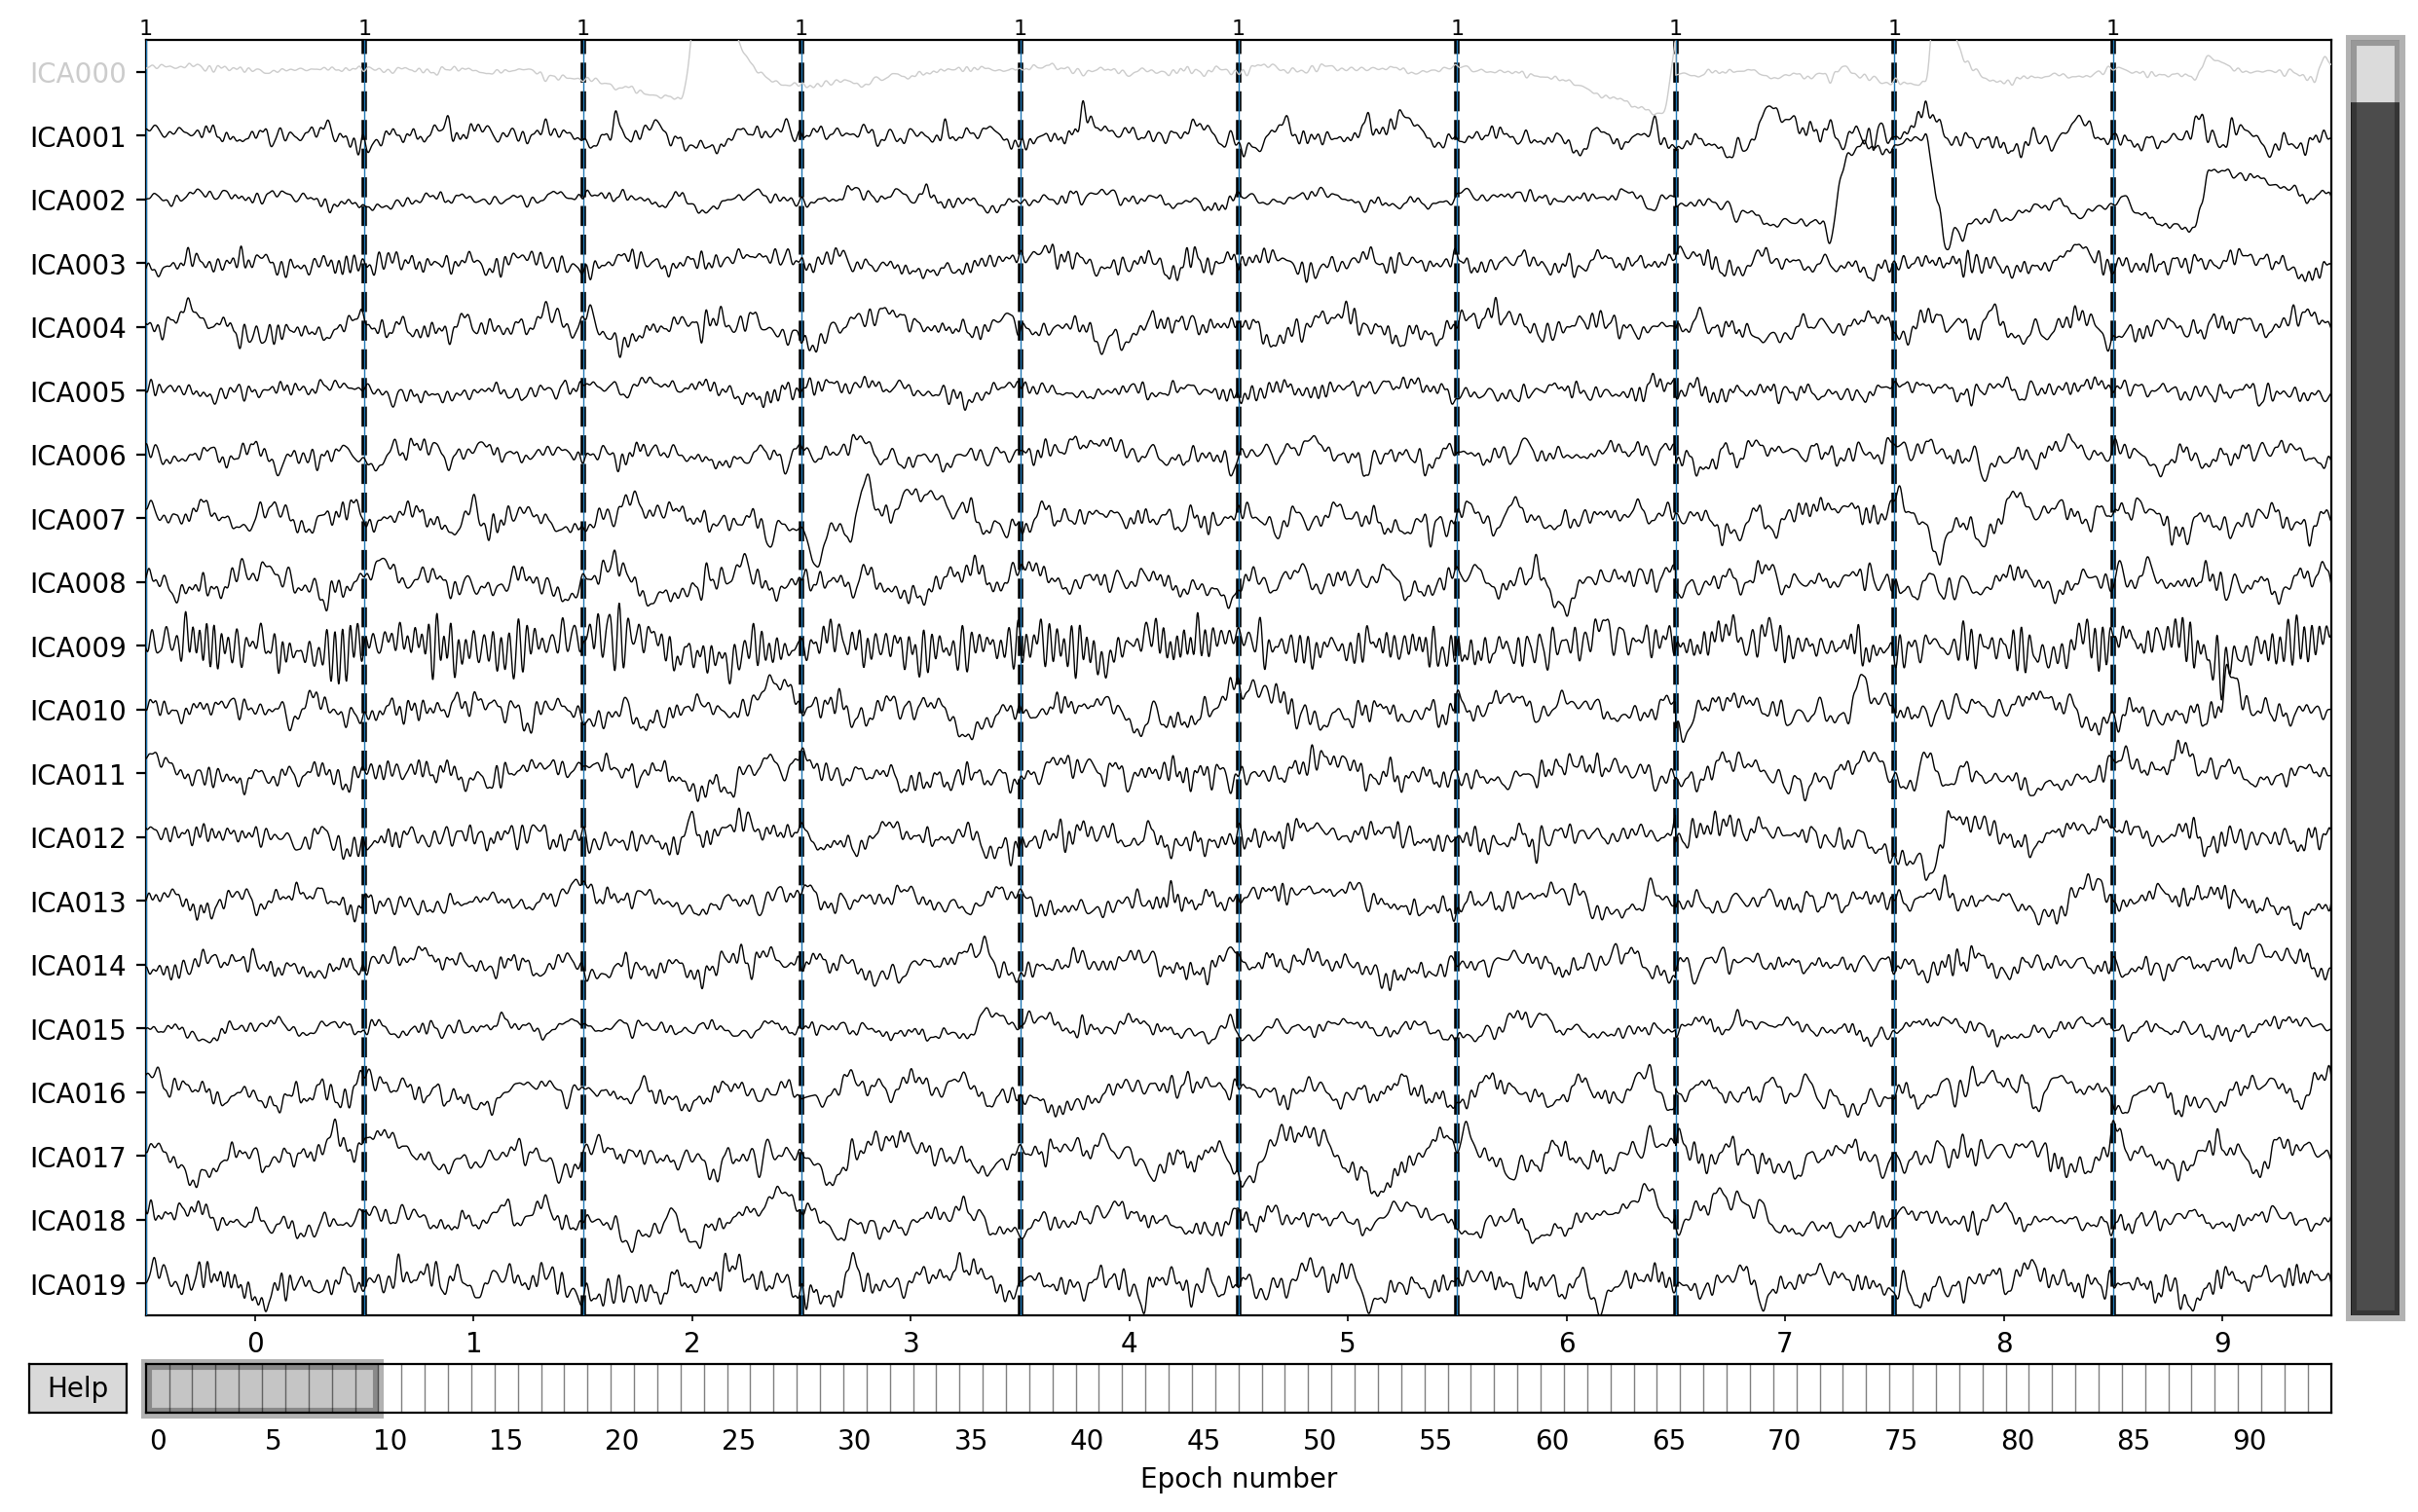

In [36]:
# Visualize components on epochs

# Exclude components by selecting them, right click on component name to visulize source:
ica.plot_sources(epochs_faster, start=0, stop=10)

In [37]:
# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_faster)
epochs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 20 PCA components


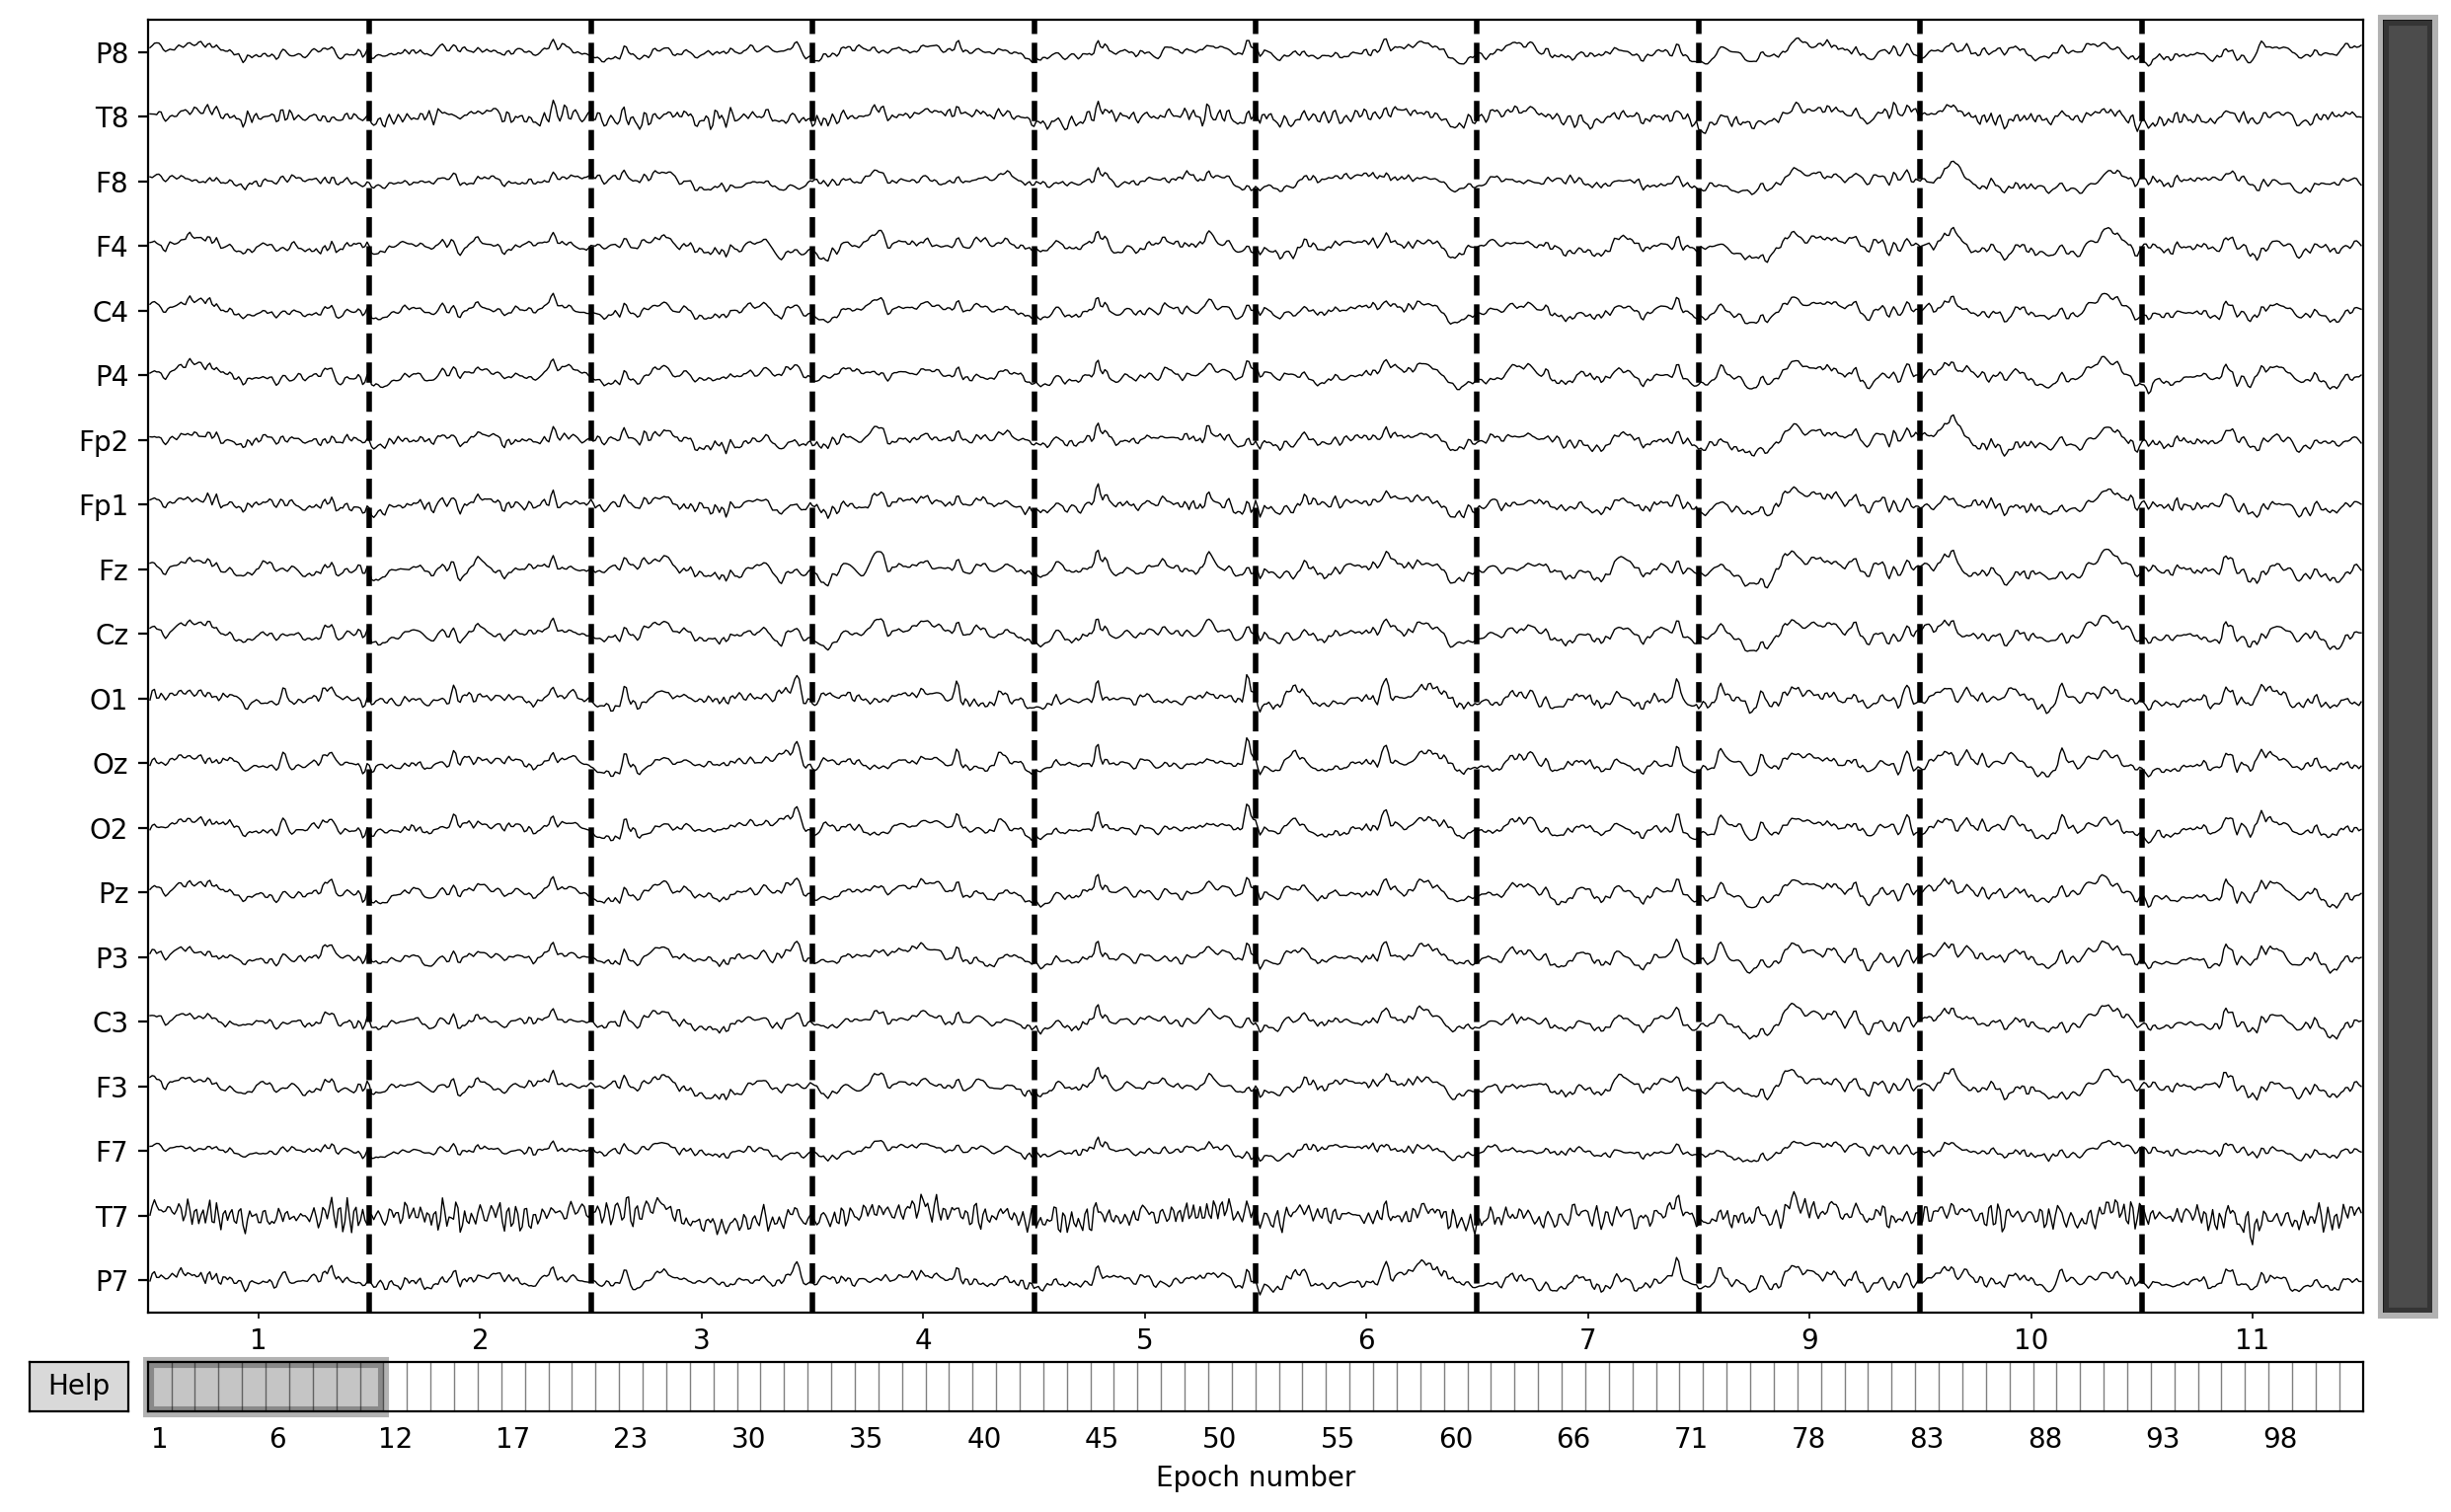

Dropped 0 epochs: 
Channels marked as bad: none


In [38]:
epochs_faster.plot(n_epochs=10, scalings={'eeg': 20e-6}, title=raw.info['fid'])

### 1.2.1 Save ICA cleaned epochs (recommended)

In [ ]:
# Create path to epoch files
interim_epochs_path = os.path.join(interim_path, 'epochs')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Save ICA cleaned epochs 
fid = epochs_faster.info['fid']
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_faster.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

## 2.1 Run Autoreject

Performs automatic rejection of bad epochs. For more information visit [this](https://www.sciencedirect.com/science/article/abs/pii/S1053811917305013) article. 

In [40]:
ar = run_autoreject(epochs_faster, n_jobs=11, subset=False)

Fitting autoreject on (n=94) epochs: 
Running autoreject on ch_type=eeg


/Users/weian/venv/neuroelectrics_eeg_pilot/lib/python3.7/site-packages/mne/bem.py:974: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/Users/weian/venv/neuroelectrics_eeg_pilot/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/weian/venv/neuroelectrics_eeg_pilot/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/weian/venv/neuroelectrics_eeg_pilot/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)








Estimated consensus=0.50 and n_interpolate=4


In [42]:
# Drop bad epochs (stage 1)

reject_log = ar.get_reject_log(epochs_faster)

epochs_autoreject = epochs_faster.copy().drop(reject_log.bad_epochs, reason='AUTOREJECT')

Dropped 14 epochs: 17, 18, 19, 21, 22, 23, 24, 36, 55, 64, 65, 69, 74, 93


In [78]:
# Drop bad epochs (stage 2) - after visual inspection
idx = np.where(np.count_nonzero(reject_log.labels, axis=1) > epochs_autoreject.info['nchan']/2)[0].tolist()
bad_epochs = [i for i in range(len(reject_log.bad_epochs)) if reject_log.bad_epochs[i]]
idx = [epoch_num for epoch_num in idx if epoch_num not in bad_epochs]

# # Plot just the bad epochs!
if idx: 
    epochs_faster[idx].plot(n_epochs=10,
                                scalings={'eeg': 20e-6},
                                n_channels=32)
    
# uncomment to drop the selected epochs
#epochs_autoreject.drop(idx, reason='AUTOREJECT')

In [ ]:
# Save Autoreject cleaned epochs 
fid = epochs_faster.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

## 3.1 Run Ransac

Visit [this](http://www.cse.yorku.ca/~kosta/CompVis_Notes/ransac.pdf) article for more information.

In [79]:
epochs_ransac = run_ransac(epochs_autoreject)

Iterating epochs ...


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


[Done]
Interpolating bad channels


[Parallel(n_jobs=11)]: Done   2 out of   8 | elapsed:    4.2s remaining:   12.7s
[Parallel(n_jobs=11)]: Done   3 out of   8 | elapsed:    4.3s remaining:    7.1s
[Parallel(n_jobs=11)]: Done   4 out of   8 | elapsed:    4.3s remaining:    4.3s
[Parallel(n_jobs=11)]: Done   5 out of   8 | elapsed:    4.3s remaining:    2.6s
[Parallel(n_jobs=11)]: Done   6 out of   8 | elapsed:    4.3s remaining:    1.4s
[Parallel(n_jobs=11)]: Done   8 out of   8 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=11)]: Done   8 out of   8 | elapsed:    4.3s finished


    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 19 sensor positions
Interpolating 1 sensors


In [81]:
print(epochs_ransac.info)

<Info | 10 non-empty values
 bads: []
 ch_names: P8, T8, F8, F4, C4, P4, Fp2, Fp1, Fz, Cz, O1, Oz, O2, Pz, P3, ...
 chs: 20 EEG
 custom_ref_applied: False
 description: n_components: 2, interpolated: T7
 dig: 20 items (20 EEG)
 fid: 20210514172935_12_EEG PALT alatt.easy_converted_
 highpass: 1.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2021-05-14 17:29:44 UTC
 nchan: 20
 projs: []
 sfreq: 500.0 Hz
>


## 4.1 Final visual inspection

Mark epochs that should be dropped, select electrodes that should be interpolated etc.

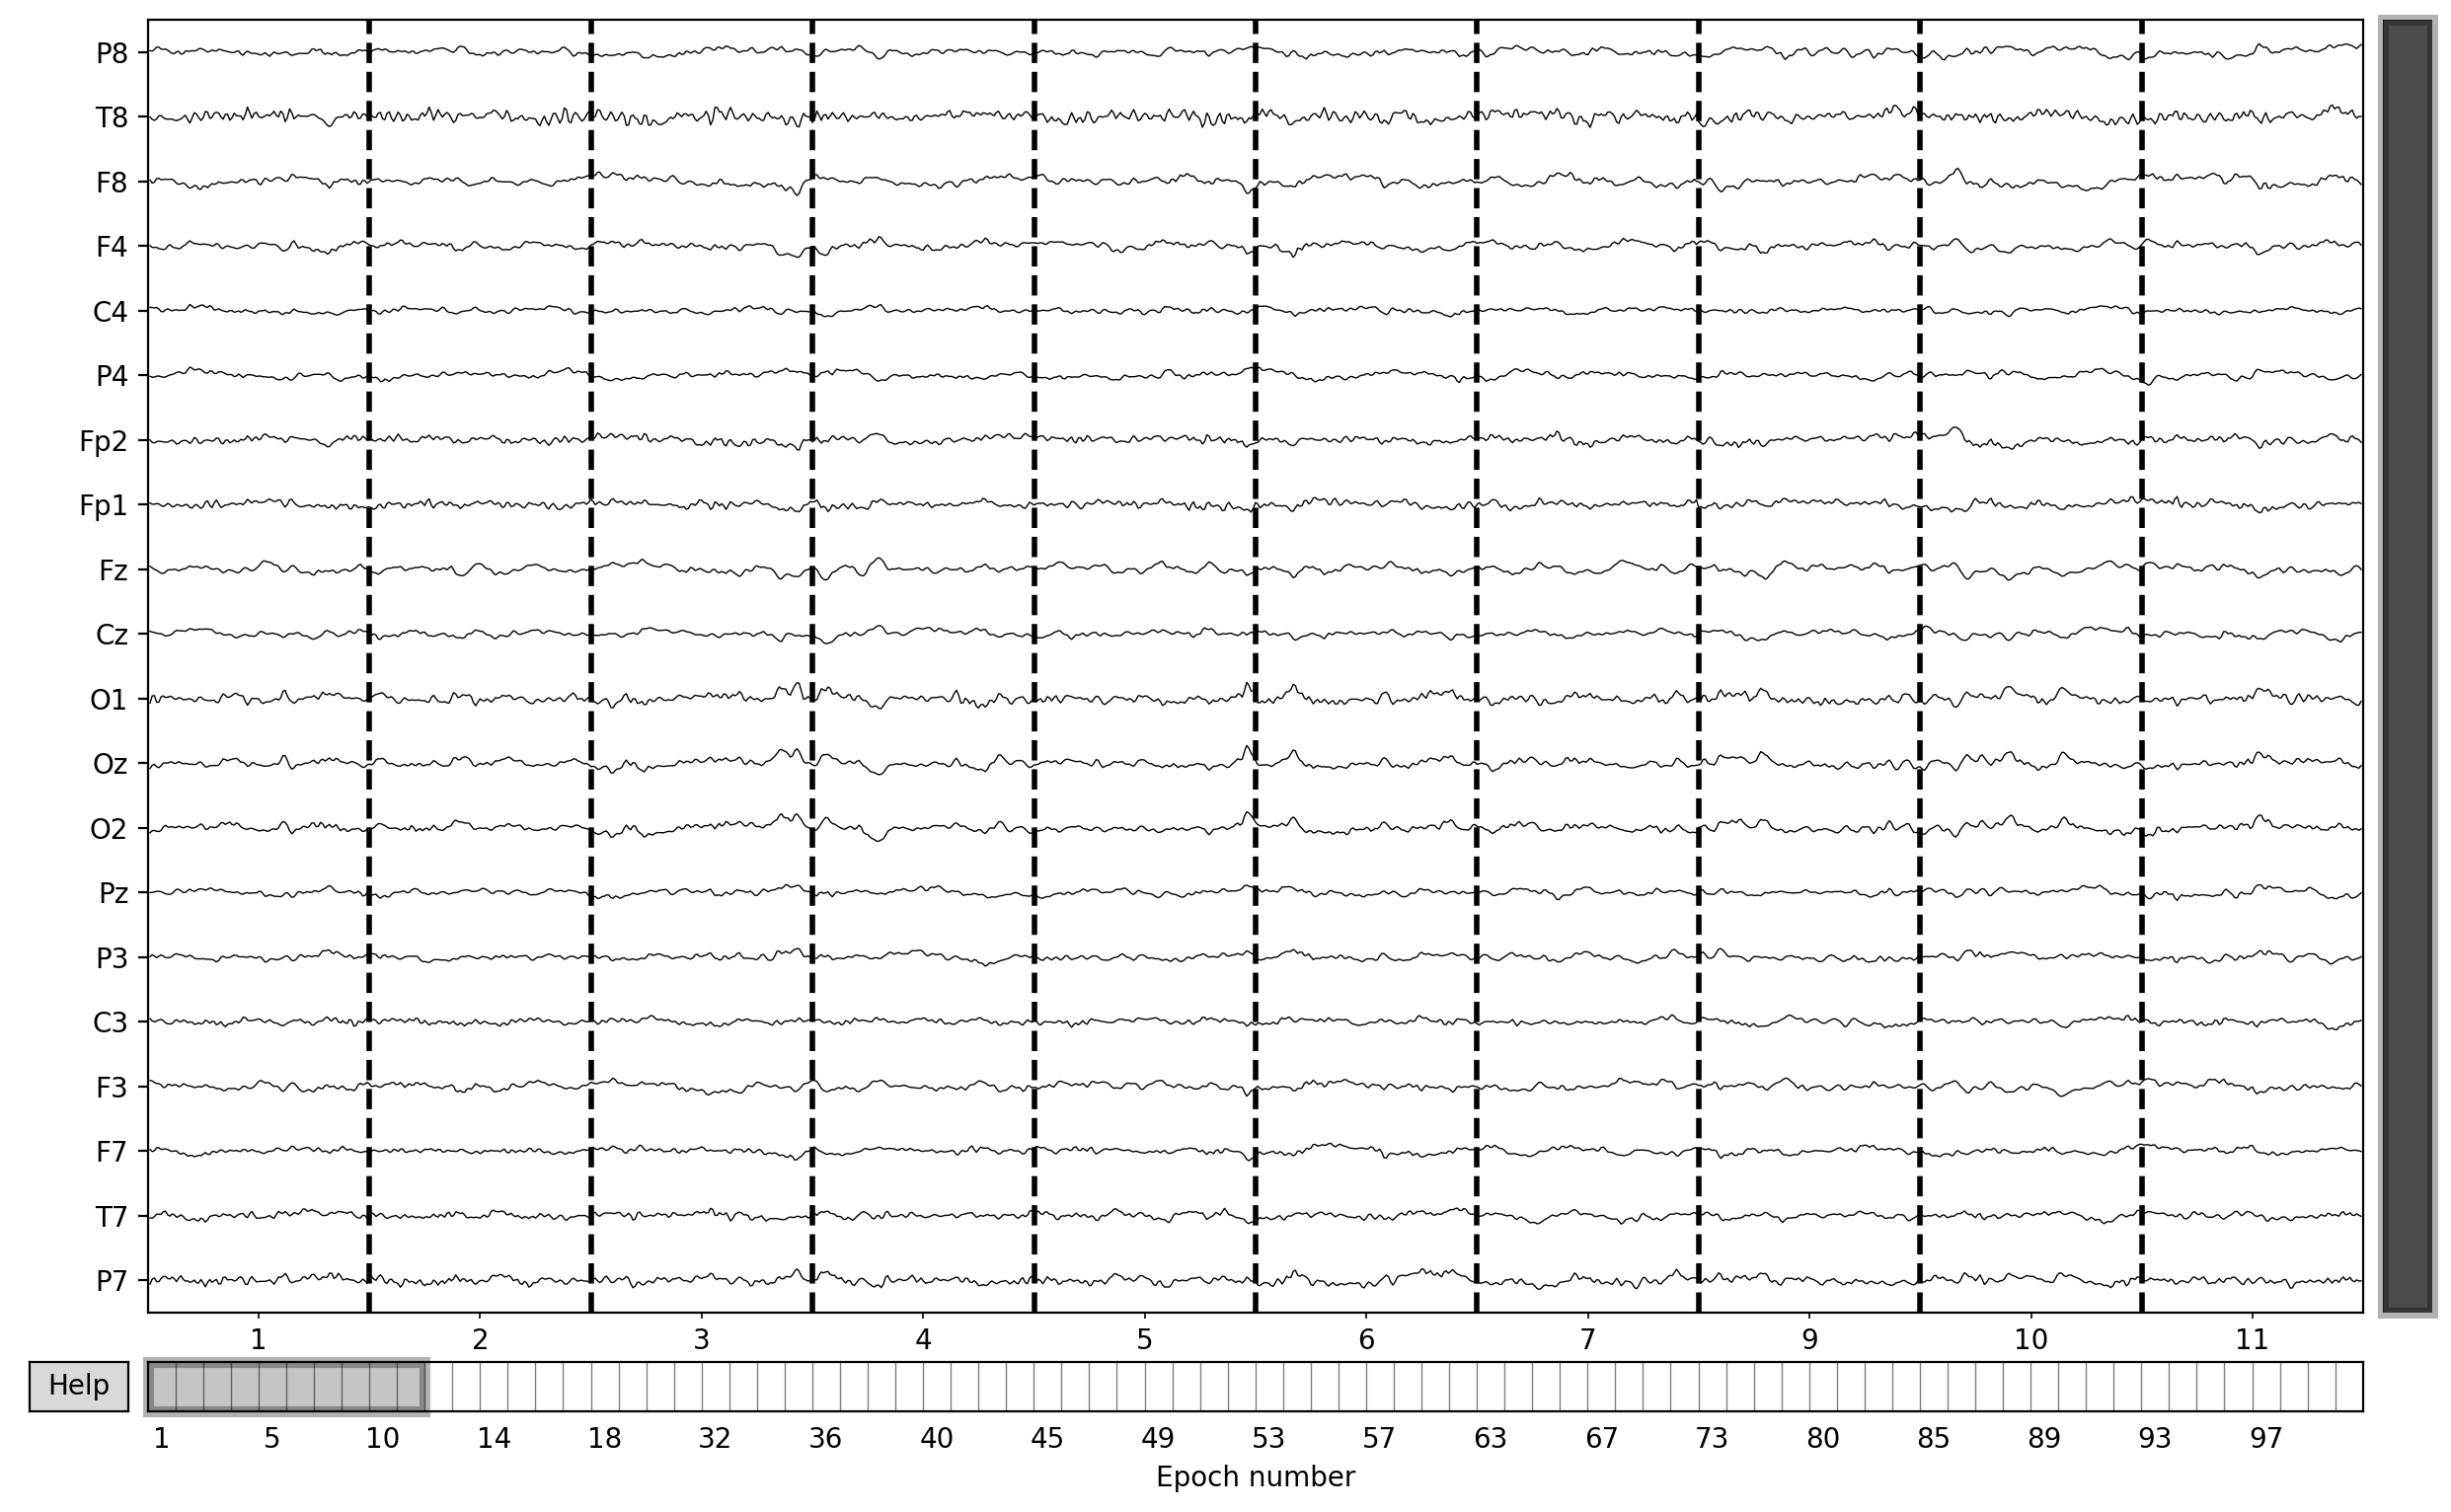

Dropped 0 epochs: 
Channels marked as bad: none


In [85]:
epochs_ransac.plot(n_epochs=10,
                       n_channels=32,
                       #group_by='position',
                       scalings={'eeg': 20e-6})

In [82]:
epochs_ransac.set_eeg_reference()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


Number of events,80
Events,1: 80
Time range,0.000 – 0.998 sec
Baseline,off


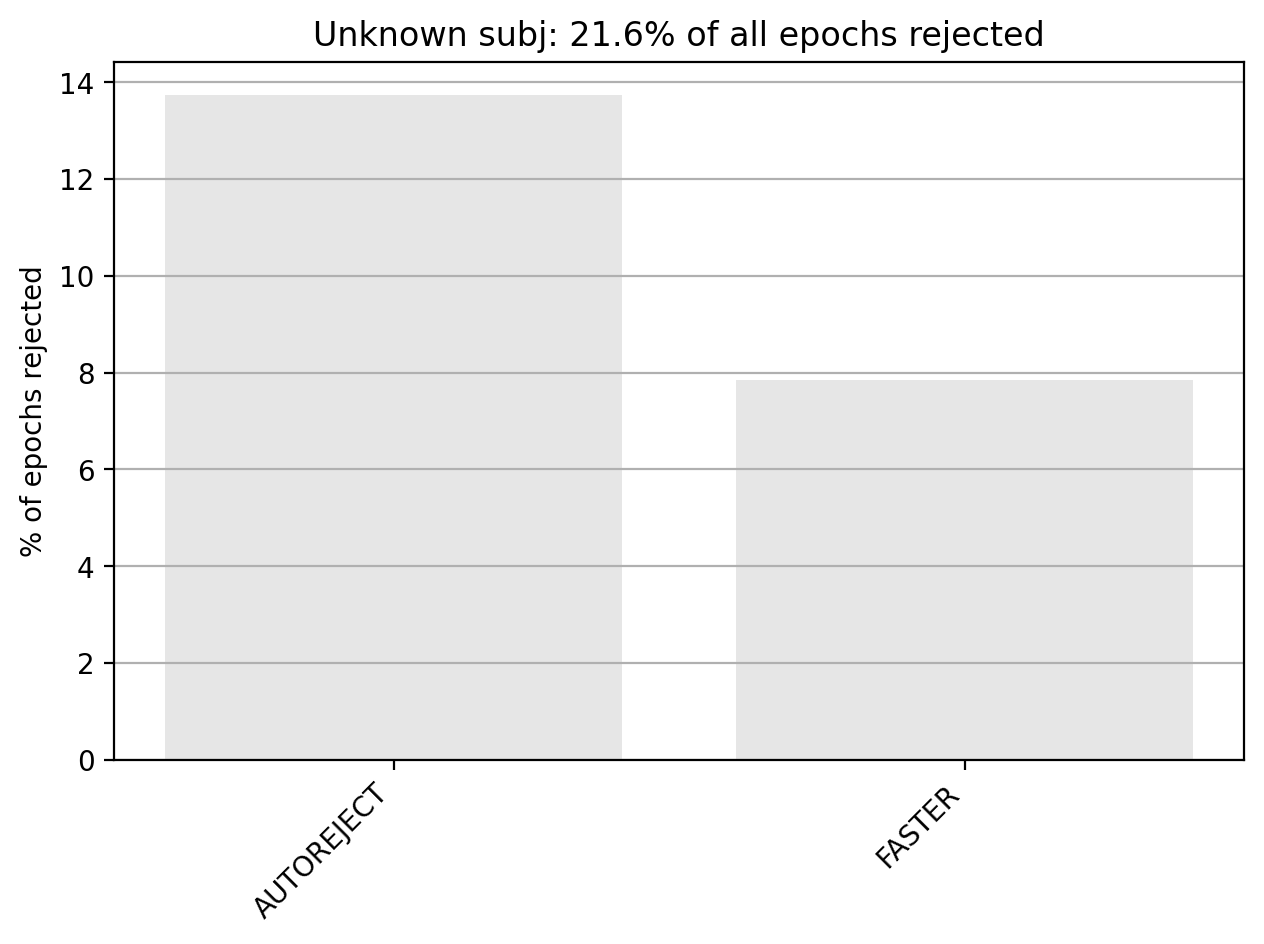

In [100]:
epochs_ransac.plot_drop_log()

In [ ]:
# Save Ransac cleaned epochs 
fid = epochs_faster.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)